In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import tensorflow as tf
import keras
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential, load_model, Model, Input
from keras.utils import np_utils, plot_model, to_categorical
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D ,MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, UpSampling2D, concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras import backend as K 

Using TensorFlow backend.


In [2]:
from keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet201,preprocess_input
from keras.applications import VGG16

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4354830879496575609
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13593938621917598761
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12570735613817017331
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10654568960
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2757488003603498665
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:09:00.0, compute capability: 7.5"
]


In [4]:
os.environ['CUDA_VISIBLE_DEVICES']="0"
config=tf.compat.v1.ConfigProto() 
config.gpu_options.visible_device_list = '0' 
config.gpu_options.allow_growth = True 
sess=tf.compat.v1.Session(config=config)

In [5]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
cpus = tf.config.experimental.list_physical_devices(device_type='CPU')
print(tf.test.is_gpu_available())
print(gpus)
print(cpus)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


# Processing 

In [6]:
#讀取圖片名稱、label名稱，將label轉為數值
def Picture_len(status):
    data = pd.read_csv(f'Dataset/Mango/DATA/{status}.csv')
    #轉為OneHotEncoder
    onehotencoder = OneHotEncoder(sparse=False)
    labelencoder = LabelEncoder()
#     print(data['label'])
    label = onehotencoder.fit_transform(data[['label']])
    label_labelencoder = labelencoder.fit_transform(data[['label']])
    Picture_label = label
    Picture_name = data['image_id'].to_numpy()
#     print(Picture_label)
    return Picture_name, Picture_label, label_labelencoder


def Picture_processing(img_path, csv_name):
    picture_pixel = 112
    picture_data = []
    pictures, picture_label, label_labelencoder = Picture_len(csv_name)
    #讀取圖片並縮小
    for picture in pictures:
        Picture_raw = cv2.imread(f'Dataset/Mango/DATA/{img_path}/{picture}')
        Picture_raw = cv2.resize(Picture_raw,(picture_pixel,picture_pixel),interpolation=cv2.INTER_AREA)
        picture_data.append(Picture_raw)
        
    picture_data = np.array(picture_data)
    
    return picture_data, picture_label, label_labelencoder

def plot_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left') 
    plt.show()


In [7]:
train_x, train_y, label_labelencoder_x = Picture_processing('Train_Image', 'train')
test_x, test_y, label_labelencoder_y = Picture_processing('Test_Image', 'test')

/user_data/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/user_data/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [8]:
train_x = train_x/255
test_x = test_x/255

# 模型訓練

# ResNet50

In [46]:

net = ResNet50(include_top=False, input_tensor=None,weights="imagenet",
                input_shape=(112,112,3))

# net.trainable = False
model = Sequential()
model.add(net)
model.add(Flatten()) 
model.add(Dropout(0.3)) 
model.add(Dense(256, activation='relu')) 
model.add(Dense(3, activation='softmax')) 

print(model.summary())

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
modelcheckpoint = keras.callbacks.ModelCheckpoint(filepath='py/ResNet50/resnet50_n2', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
reduceLronplateau = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=7, verbose=1, mode='auto', min_delta=0.001, cooldown=0, min_lr=0)

model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(lr=1e-4), metrics = ['accuracy'])

history = model.fit(train_x[:5000],train_y[:5000], epochs=500, batch_size=32, verbose=1,validation_data=(train_x[5000:],train_y[5000:]), callbacks=[modelcheckpoint, earlystopping, reduceLronplateau])


/user_data/.local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten_12 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 32768)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               8388864   
_________________________________________________________________
dense_24 (Dense)             (None, 3)                 771       
Total params: 31,977,347
Trainable params: 31,924,227
Non-trainable params: 53,120
_________________________________________________________________
None
Train on 5000 samples, validate on 1130 samples
Epoch 1/500
5000/5000 [==========================

250/250 [==============================] - 0s 1ms/step
Loss: 2.7730578327178956
Accuracy: 0.7599999904632568
predict accurscy: 0.76, precision: 0.7603586341910424, recall: 0.7703373015873015, f1: 0.7630959664414633


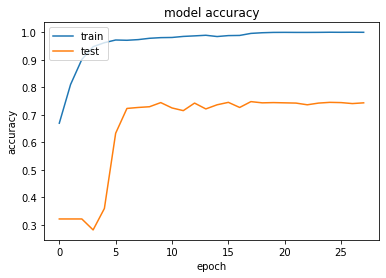

In [47]:
#測試資料
# model.load_weights('py/ResNet50/resnet50_n')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(test_x,test_y)
pred_cy = model.predict_classes(test_x)

precision = precision_score(label_labelencoder_y, pred_cy, average='macro')
recall = recall_score(label_labelencoder_y, pred_cy, average='macro')
acc = accuracy_score(label_labelencoder_y, pred_cy)

f1 = f1_score(label_labelencoder_y, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}')
plot_acc(history)



In [48]:
#最好權重模型-測試資料
model.load_weights('py/ResNet50/resnet50_n2')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(test_x,test_y)
pred_cy = model.predict_classes(test_x)

precision = precision_score(label_labelencoder_y, pred_cy, average='macro')
recall = recall_score(label_labelencoder_y, pred_cy, average='macro')
acc = accuracy_score(label_labelencoder_y, pred_cy)

f1 = f1_score(label_labelencoder_y, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}')
# plot_acc(history)



250/250 [==============================] - 0s 845us/step
Loss: 2.0494774894714354
Accuracy: 0.7360000014305115
predict accurscy: 0.736, precision: 0.7392053327341497, recall: 0.7428571428571429, f1: 0.7408415448888576


In [49]:
#最好權重模型-訓練資料
model.load_weights('py/ResNet50/resnet50_n2')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(train_x,train_y)
pred_cy = model.predict_classes(train_x)

precision = precision_score(label_labelencoder_x, pred_cy, average='macro')
recall = recall_score(label_labelencoder_x, pred_cy, average='macro')
acc = accuracy_score(label_labelencoder_x, pred_cy)

f1 = f1_score(label_labelencoder_x, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}')
# plot_acc(history)



6130/6130 [==============================] - 5s 869us/step
Loss: 0.5412534726157022
Accuracy: 0.9533442258834839
predict accurscy: 0.9533442088091354, precision: 0.9544648239031318, recall: 0.9536854464693164, f1: 0.954009026466052


In [16]:

net = ResNet50(include_top=False, input_tensor=None,weights="imagenet",
                input_shape=(224,224,3))

# net.trainable = False
model = Sequential()
model.add(net)
model.add(Flatten()) 
model.add(Dropout(0.3)) 
model.add(Dense(256, activation='relu')) 
model.add(Dense(3, activation='softmax')) 

print(model.summary())

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30)
modelcheckpoint = keras.callbacks.ModelCheckpoint(filepath='py/ResNet50/resnet50_n', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
reduceLronplateau = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.001, cooldown=0, min_lr=0)

model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(lr=1e-4), metrics = ['accuracy'])

history = model.fit(train_x[:5000],train_y[:5000], epochs=500, batch_size=32, verbose=1,validation_data=(train_x[5000:],train_y[5000:]), callbacks=[modelcheckpoint, earlystopping, reduceLronplateau])


/user_data/.local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 49,278,851
Trainable params: 49,225,731
Non-trainable params: 53,120
_________________________________________________________________
None
Train on 5000 samples, validate on 1130 samples
Epoch 1/500
5000/5000 [===========================

250/250 [==============================] - 1s 4ms/step
Loss: 1.5471777222156524
Accuracy: 0.8159999847412109
predict accurscy: 0.816, precision: 0.8158465113053128, recall: 0.8283730158730158, f1: 0.8187866714564079


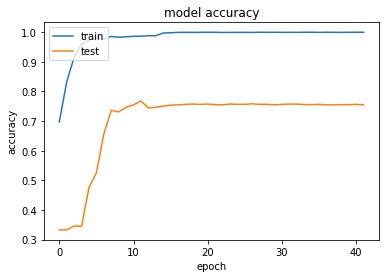

In [17]:
#測試資料
# model.load_weights('py/ResNet50/resnet50_n')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(test_x,test_y)
pred_cy = model.predict_classes(test_x)

precision = precision_score(label_labelencoder_y, pred_cy, average='macro')
recall = recall_score(label_labelencoder_y, pred_cy, average='macro')
acc = accuracy_score(label_labelencoder_y, pred_cy)

f1 = f1_score(label_labelencoder_y, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}')
plot_acc(history)



In [18]:
#最好權重模型-測試資料
model.load_weights('py/ResNet50/resnet50_n')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(test_x,test_y)
pred_cy = model.predict_classes(test_x)

precision = precision_score(label_labelencoder_y, pred_cy, average='macro')
recall = recall_score(label_labelencoder_y, pred_cy, average='macro')
acc = accuracy_score(label_labelencoder_y, pred_cy)

f1 = f1_score(label_labelencoder_y, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}')
# plot_acc(history)



250/250 [==============================] - 1s 3ms/step
Loss: 1.682476165652275
Accuracy: 0.8040000200271606
predict accurscy: 0.804, precision: 0.8047732362821948, recall: 0.8163690476190476, f1: 0.8050849229161222


In [19]:
#最好權重模型-訓練資料
model.load_weights('py/ResNet50/resnet50_n')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(train_x,train_y)
pred_cy = model.predict_classes(train_x)

precision = precision_score(label_labelencoder_x, pred_cy, average='macro')
recall = recall_score(label_labelencoder_x, pred_cy, average='macro')
acc = accuracy_score(label_labelencoder_x, pred_cy)

f1 = f1_score(label_labelencoder_x, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}')
# plot_acc(history)



6130/6130 [==============================] - 16s 3ms/step
Loss: 0.703574087951503
Accuracy: 0.9526916742324829
predict accurscy: 0.9526916802610114, precision: 0.9527934030822762, recall: 0.9542059070162571, f1: 0.9533643734585756


### 資料增強

In [9]:

net = ResNet50(include_top=False, input_tensor=None,weights="imagenet",
                input_shape=(224,224,3))

# net.trainable = False
model = Sequential()
model.add(net)
model.add(Flatten()) 
model.add(Dropout(0.3)) 
model.add(Dense(256, activation='relu')) 
model.add(Dense(3, activation='softmax')) 


print(model.summary())

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30)
modelcheckpoint = keras.callbacks.ModelCheckpoint(filepath='py/ResNet50/resnet50', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
reduceLronplateau = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.001, cooldown=0, min_lr=0)

model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(lr=1e-4), metrics = ['accuracy'])
# train_datagen = ImageDataGenerator(rescale = 1./255)
# test_datagen = ImageDataGenerator(rescale = 1./255)

# train_datagen = ImageDataGenerator(rotation_range=0.2, zoom_range=0.05,
#                                    featurewise_center = True, featurewise_std_normalization = True,
#                                     width_shift_range=0.05, height_shift_range=0.05, shear_range=0.05,
#                                     horizontal_flip=True, fill_mode="nearest")

# train_datagen=ImageDataGenerator(rotation_range=5 , 
#                              width_shift_range=0.2 , 
#                              height_shift_range=0.2 ,
#                              shear_range=0.2 ,
#                              zoom_range=0.2 , 
#                              data_format='channels_last')

# train_datagen.fit(train_x)

# history = model.fit_generator(train_datagen.flow(train_x[:5000],train_y[:5000],batch_size=20), 
#                               steps_per_epoch=len(train_x[:5000]) / 20 , epochs=500,
#                               validation_data=(train_x[5000:],train_y[5000:]),validation_steps=len(train_x[5000:]) / 20,
#                               callbacks=[modelcheckpoint, earlystopping, reduceLronplateau])

/user_data/.local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 49,278,851
Trainable params: 49,225,731
Non-trainable params: 53,120
_________________________________________________________________
None


250/250 [==============================] - 1s 5ms/step
Loss: 0.6872671039104462
Accuracy: 0.8199999928474426
predict accurscy: 0.82, precision: 0.819412591508728, recall: 0.8305555555555556, f1: 0.822094061643304


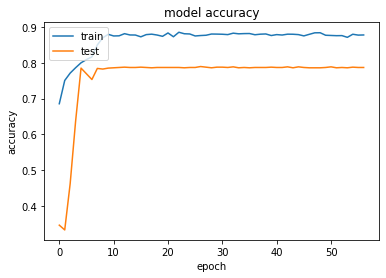

In [11]:
#測試資料
# model.load_weights('py/ResNet50/resnet50')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(test_x,test_y)
pred_cy = model.predict_classes(test_x)

precision = precision_score(label_labelencoder_y, pred_cy, average='macro')
recall = recall_score(label_labelencoder_y, pred_cy, average='macro')
acc = accuracy_score(label_labelencoder_y, pred_cy)

f1 = f1_score(label_labelencoder_y, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}')
plot_acc(history)



In [12]:
#最好權重模型-測試資料
model.load_weights('py/ResNet50/resnet50')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(test_x,test_y)
pred_cy = model.predict_classes(test_x)

precision = precision_score(label_labelencoder_y, pred_cy, average='macro')
recall = recall_score(label_labelencoder_y, pred_cy, average='macro')
acc = accuracy_score(label_labelencoder_y, pred_cy)

f1 = f1_score(label_labelencoder_y, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}')
# plot_acc(history)



250/250 [==============================] - 1s 3ms/step
Loss: 0.7012974712848663
Accuracy: 0.8199999928474426
predict accurscy: 0.82, precision: 0.819412591508728, recall: 0.8305555555555556, f1: 0.822094061643304


In [19]:
#最好權重模型-訓練資料
model.load_weights('py/ResNet50/resnet50')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(train_x,train_y)
pred_cy = model.predict_classes(train_x)

precision = precision_score(label_labelencoder_x, pred_cy, average='macro')
recall = recall_score(label_labelencoder_x, pred_cy, average='macro')
acc = accuracy_score(label_labelencoder_x, pred_cy)

f1 = f1_score(label_labelencoder_x, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}')
# plot_acc(history)



6130/6130 [==============================] - 18s 3ms/step
Loss: 0.40334094445332036
Accuracy: 0.8835236430168152
predict accurscy: 0.8835236541598694, precision: 0.8847058935942508, recall: 0.8864093650354699, f1: 0.8854736177734309


# DenseNet201

In [11]:
DenseNet201_model = DenseNet201(include_top=False, weights="imagenet", input_shape=(112,112,3))
# model = add_new_last_layer(model, 3)

# net.trainable = False
model = Sequential()
model.add(DenseNet201_model)
# model.add(Dropout(0.2))
# model.add(Conv2D(256, (3, 3), activation = 'relu', padding='same'))
model.add(Flatten()) 
model.add(Dropout(0.5)) 
model.add(Dense(512, activation='relu')) 
# model.add(Dense(128, activation='relu')) 
# model.add(Dropout(0.1)) 
model.add(Dense(3, activation='softmax')) 


print(model.summary())


earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
modelcheckpoint = keras.callbacks.ModelCheckpoint(filepath='py/DenseNet201/densenet201_2_n', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
# reduceLronplateau = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.001, cooldown=0, min_lr=0)
reduceLronplateau=ReduceLROnPlateau(monitor='val_accuracy',
                             patience=7,
                             # 3 epochs 內acc沒下降就要調整LR
                             verbose=1,
                             factor=0.5,
                             # LR降為0.5
                             min_lr=0.00001
                             # 最小 LR 到0.00001就不再下降
                             )
model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(lr=1e-4), metrics = ['accuracy'])
history = model.fit(train_x[:5000],train_y[:5000], epochs=500, batch_size=32, verbose=1,validation_data=(train_x[5000:],train_y[5000:]), callbacks=[modelcheckpoint, earlystopping, reduceLronplateau])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 3, 3, 1920)        18321984  
_________________________________________________________________
flatten_2 (Flatten)          (None, 17280)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 17280)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               8847872   
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 1539      
Total params: 27,171,395
Trainable params: 26,942,339
Non-trainable params: 229,056
_________________________________________________________________
None
Train on 5000 samples, validate on 1130 samples
Epoch 1/500
5000/5000 [==========================

250/250 [==============================] - 1s 5ms/step
Loss: 3.0776201152801512
Accuracy: 0.7559999823570251
predict accurscy: 0.756, precision: 0.7579872697519757, recall: 0.7660714285714286, f1: 0.7605567248384929


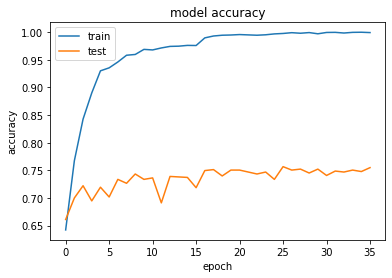

In [12]:

model.load_weights('py/DenseNet201/densenet201_2_n')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(test_x,test_y)
pred_cy = model.predict_classes(test_x)

precision = precision_score(label_labelencoder_y, pred_cy, average='macro')
recall = recall_score(label_labelencoder_y, pred_cy, average='macro')
acc = accuracy_score(label_labelencoder_y, pred_cy)

f1 = f1_score(label_labelencoder_y, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}')
plot_acc(history)



In [13]:
#測試集預測
model.load_weights('py/DenseNet201/densenet201_2_n')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(test_x,test_y)
pred_cy = model.predict_classes(test_x)

precision = precision_score(label_labelencoder_y, pred_cy, average='macro')
recall = recall_score(label_labelencoder_y, pred_cy, average='macro')
acc = accuracy_score(label_labelencoder_y, pred_cy)

f1 = f1_score(label_labelencoder_y, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}')
# plot_acc(history)



250/250 [==============================] - 0s 2ms/step
Loss: 3.0776201152801512
Accuracy: 0.7559999823570251
predict accurscy: 0.756, precision: 0.7579872697519757, recall: 0.7660714285714286, f1: 0.7605567248384929


In [14]:
#訓練集預測
model.load_weights('py/DenseNet201/densenet201_2_n')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(train_x,train_y)
pred_cy = model.predict_classes(train_x)

precision = precision_score(label_labelencoder_x, pred_cy, average='macro')
recall = recall_score(label_labelencoder_x, pred_cy, average='macro')
acc = accuracy_score(label_labelencoder_x, pred_cy)

f1 = f1_score(label_labelencoder_x, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}')
# plot_acc(history)



6130/6130 [==============================] - 11s 2ms/step
Loss: 0.7094301913730653
Accuracy: 0.9551386833190918
predict accurscy: 0.9551386623164764, precision: 0.9562045383582559, recall: 0.955614148603526, f1: 0.9558733966297362


### 資料增強

In [20]:
DenseNet201_model = DenseNet201(include_top=False, weights="imagenet", input_shape=(224,224,3))
# model = add_new_last_layer(model, 3)

# net.trainable = False
model = Sequential()
model.add(DenseNet201_model)
# model.add(Dropout(0.2))
# model.add(Conv2D(256, (3, 3), activation = 'relu', padding='same'))
model.add(Flatten()) 
model.add(Dropout(0.5)) 
model.add(Dense(512, activation='relu')) 
# model.add(Dense(128, activation='relu')) 
# model.add(Dropout(0.1)) 
model.add(Dense(3, activation='softmax')) 

# x = base_model.output
# x = Flatten()(x)
# x = Dense(128, activation='relu')(x)
# # # 增加 DropOut layer
# x = Dropout(0.5)(x)
# x = Dense(64, activation='relu')(x)
# output_layer = Dense(3, activation='softmax')(x)
# model = Model(inputs=base_model.input, outputs=output_layer)

print(model.summary())


earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
modelcheckpoint = keras.callbacks.ModelCheckpoint(filepath='py/DenseNet201/densenet201_2', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
# reduceLronplateau = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.001, cooldown=0, min_lr=0)
reduceLronplateau=ReduceLROnPlateau(monitor='val_accuracy',
                             patience=7,
                             # 3 epochs 內acc沒下降就要調整LR
                             verbose=1,
                             factor=0.5,
                             # LR降為0.5
                             min_lr=0.00001
                             # 最小 LR 到0.00001就不再下降
                             )
model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(lr=1e-4), metrics = ['accuracy'])
# train_datagen = ImageDataGenerator(rescale = 1./255)
# test_datagen = ImageDataGenerator(rescale = 1./255)
# train_datagen = ImageDataGenerator(rotation_range=0.2, zoom_range=0.05,
#                                    featurewise_center = True, featurewise_std_normalization = True,
#                                     width_shift_range=0.05, height_shift_range=0.05, shear_range=0.05,
#                                     horizontal_flip=True, fill_mode="nearest")

# train_datagen=ImageDataGenerator(rotation_range=15 , 
#                              width_shift_range=0.2 , 
#                              height_shift_range=0.2 ,
#                              shear_range=0.2 ,
#                              zoom_range=0.2 , 
#                              data_format='channels_last')

# train_datagen.fit(train_x)

# history = model.fit_generator(train_datagen.flow(train_x[:5000],train_y[:5000],batch_size=20), 
#                               steps_per_epoch=100 , epochs=500,
#                               validation_data=(train_x[5000:],train_y[5000:]),validation_steps=100,
#                               callbacks=[modelcheckpoint, earlystopping, reduceLronplateau])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 7, 7, 1920)        18321984  
_________________________________________________________________
flatten_2 (Flatten)          (None, 94080)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 94080)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               48169472  
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 1539      
Total params: 66,492,995
Trainable params: 66,263,939
Non-trainable params: 229,056
_________________________________________________________________
None


250/250 [==============================] - 1s 5ms/step
Loss: 1.3140835013389587
Accuracy: 0.8119999766349792
predict accurscy: 0.812, precision: 0.8135405053883314, recall: 0.8206349206349207, f1: 0.8159651608016943


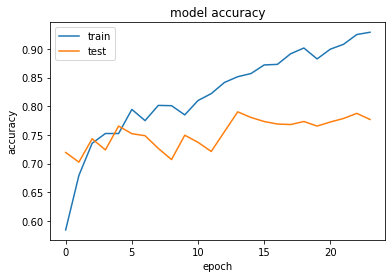

In [22]:

# model.load_weights('py/mango')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(test_x,test_y)
pred_cy = model.predict_classes(test_x)

precision = precision_score(label_labelencoder_y, pred_cy, average='macro')
recall = recall_score(label_labelencoder_y, pred_cy, average='macro')
acc = accuracy_score(label_labelencoder_y, pred_cy)

f1 = f1_score(label_labelencoder_y, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}')
plot_acc(history)



In [23]:
#測試集預測
model.load_weights('py/DenseNet201/densenet201_2')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(test_x,test_y)
pred_cy = model.predict_classes(test_x)

precision = precision_score(label_labelencoder_y, pred_cy, average='macro')
recall = recall_score(label_labelencoder_y, pred_cy, average='macro')
acc = accuracy_score(label_labelencoder_y, pred_cy)

f1 = f1_score(label_labelencoder_y, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}')
# plot_acc(history)



250/250 [==============================] - 1s 5ms/step
Loss: 0.7850775408744812
Accuracy: 0.828000009059906
predict accurscy: 0.828, precision: 0.8286215816703623, recall: 0.8373015873015873, f1: 0.8305101300440922


In [21]:
#訓練集預測
model.load_weights('py/DenseNet201/densenet201_2')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(train_x,train_y)
pred_cy = model.predict_classes(train_x)

precision = precision_score(label_labelencoder_x, pred_cy, average='macro')
recall = recall_score(label_labelencoder_x, pred_cy, average='macro')
acc = accuracy_score(label_labelencoder_x, pred_cy)

f1 = f1_score(label_labelencoder_x, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}')
# plot_acc(history)



6130/6130 [==============================] - 35s 6ms/step
Loss: 0.30890823635736064
Accuracy: 0.8928222060203552
predict accurscy: 0.8928221859706362, precision: 0.8935311121783399, recall: 0.8959252299122826, f1: 0.8945200541916689


# CNN

In [9]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (112,112,3), padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
# model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
# model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))
print(model.summary())



earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30)
modelcheckpoint = keras.callbacks.ModelCheckpoint(filepath='py/CNN/cnn_n2', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
# reduceLronplateau = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, verbose=1, mode='auto', min_delta=0.001, cooldown=0, min_lr=0)
reduceLronplateau=ReduceLROnPlateau(monitor='val_accuracy',
                             patience=25,
                             # 3 epochs 內acc沒下降就要調整LR
                             verbose=1,
                             factor=0.5,
                             # LR降為0.5
                             min_lr=0.00001
                             # 最小 LR 到0.00001就不再下降
                             )

# model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(lr=1e-4), metrics = ['accuracy'])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# history = model.fit(train_x, train_y, epochs=500, batch_size=32, verbose=1, callbacks=[modelcheckpoint, earlystopping, reduceLronplateau])

history = model.fit(train_x[:5000],train_y[:5000], epochs=500, batch_size=32, verbose=1,validation_data=(train_x[5000:],train_y[5000:]), callbacks=[modelcheckpoint, earlystopping, reduceLronplateau])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 112, 112, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)      

250/250 [==============================] - 0s 328us/step
Loss: 3.5702946491241456
Accuracy: 0.7080000042915344
predict accurscy: 0.708, precision: 0.711422265639133, recall: 0.7160714285714285, f1: 0.7134830867365798


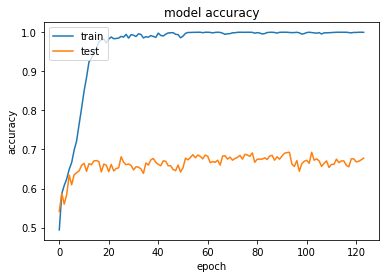

In [10]:

# model.load_weights('py/CNN/cnn_n2')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(test_x,test_y)
pred_cy = model.predict_classes(test_x)

precision = precision_score(label_labelencoder_y, pred_cy, average='macro')
recall = recall_score(label_labelencoder_y, pred_cy, average='macro')
acc = accuracy_score(label_labelencoder_y, pred_cy)

f1 = f1_score(label_labelencoder_y, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}')
plot_acc(history)




In [11]:
#測試集
model.load_weights('py/CNN/cnn_n2')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(test_x,test_y)
pred_cy = model.predict_classes(test_x)

precision = precision_score(label_labelencoder_y, pred_cy, average='macro')
recall = recall_score(label_labelencoder_y, pred_cy, average='macro')
acc = accuracy_score(label_labelencoder_y, pred_cy)

f1 = f1_score(label_labelencoder_y, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}')
# plot_acc(history)




250/250 [==============================] - 0s 177us/step
Loss: 3.3031304483413697
Accuracy: 0.6919999718666077
predict accurscy: 0.692, precision: 0.7008085708510209, recall: 0.6981150793650793, f1: 0.699393443358647


In [12]:
#訓練集
model.load_weights('py/CNN/cnn_n2')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(train_x,train_y)
pred_cy = model.predict_classes(train_x)

precision = precision_score(label_labelencoder_x, pred_cy, average='macro')
recall = recall_score(label_labelencoder_x, pred_cy, average='macro')
acc = accuracy_score(label_labelencoder_x, pred_cy)

f1 = f1_score(label_labelencoder_x, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}')
# plot_acc(history)




6130/6130 [==============================] - 1s 181us/step
Loss: 0.6858325669600878
Accuracy: 0.9433931708335876
predict accurscy: 0.9433931484502447, precision: 0.9440853525156151, recall: 0.9439263796071975, f1: 0.9440048914361681


In [42]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (112,112,3), padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
# model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(512, activation = 'relu'))
# model.add(Dense(128, activation = 'relu'))
# model.add(Dropout(0.1))
# model.add(Dense(128, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))
print(model.summary())



earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30)
modelcheckpoint = keras.callbacks.ModelCheckpoint(filepath='py/CNN/cnn_n', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
# reduceLronplateau = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, verbose=1, mode='auto', min_delta=0.001, cooldown=0, min_lr=0)
reduceLronplateau=ReduceLROnPlateau(monitor='val_accuracy',
                             patience=25,
                             # 3 epochs 內acc沒下降就要調整LR
                             verbose=1,
                             factor=0.5,
                             # LR降為0.5
                             min_lr=0.00001
                             # 最小 LR 到0.00001就不再下降
                             )

# model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(lr=1e-4), metrics = ['accuracy'])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# history = model.fit(train_x, train_y, epochs=500, batch_size=32, verbose=1, callbacks=[modelcheckpoint, earlystopping, reduceLronplateau])

history = model.fit(train_x[:5000],train_y[:5000], epochs=500, batch_size=32, verbose=1,validation_data=(train_x[5000:],train_y[5000:]), callbacks=[modelcheckpoint, earlystopping, reduceLronplateau])

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 112, 112, 32)      896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 14, 14, 64)      

250/250 [==============================] - 0s 158us/step
Loss: 1.4089090626239777
Accuracy: 0.7400000095367432
predict accurscy: 0.74, precision: 0.7454350161117077, recall: 0.747718253968254, f1: 0.745480275855576


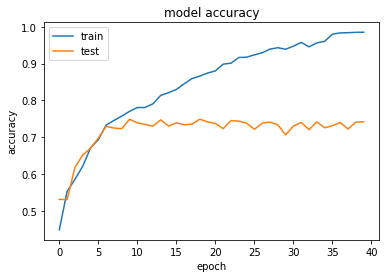

In [43]:

# model.load_weights('py/CNN/cnn_n')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(test_x,test_y)
pred_cy = model.predict_classes(test_x)

precision = precision_score(label_labelencoder_y, pred_cy, average='macro')
recall = recall_score(label_labelencoder_y, pred_cy, average='macro')
acc = accuracy_score(label_labelencoder_y, pred_cy)

f1 = f1_score(label_labelencoder_y, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}')
plot_acc(history)




In [44]:
#測試集
model.load_weights('py/CNN/cnn_n')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(test_x,test_y)
pred_cy = model.predict_classes(test_x)

precision = precision_score(label_labelencoder_y, pred_cy, average='macro')
recall = recall_score(label_labelencoder_y, pred_cy, average='macro')
acc = accuracy_score(label_labelencoder_y, pred_cy)

f1 = f1_score(label_labelencoder_y, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}')
# plot_acc(history)




250/250 [==============================] - 0s 171us/step
Loss: 0.5853228583335877
Accuracy: 0.7680000066757202
predict accurscy: 0.768, precision: 0.7757390845006285, recall: 0.7851190476190476, f1: 0.767297953090119


In [45]:
#訓練集
model.load_weights('py/CNN/cnn_n')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(train_x,train_y)
pred_cy = model.predict_classes(train_x)

precision = precision_score(label_labelencoder_x, pred_cy, average='macro')
recall = recall_score(label_labelencoder_x, pred_cy, average='macro')
acc = accuracy_score(label_labelencoder_x, pred_cy)

f1 = f1_score(label_labelencoder_x, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}')
# plot_acc(history)




6130/6130 [==============================] - 1s 160us/step
Loss: 0.4932718079348762
Accuracy: 0.7796084880828857
predict accurscy: 0.7796084828711256, precision: 0.7875266774027808, recall: 0.791002093749614, f1: 0.7781541584377009


### 資料增強

In [25]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (224,224,3), padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
# model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(512, activation = 'relu'))
# model.add(Dense(128, activation = 'relu'))
# model.add(Dropout(0.1))
# model.add(Dense(128, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))
print(model.summary())



earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30)
modelcheckpoint = keras.callbacks.ModelCheckpoint(filepath='py/CNN/cnn', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
# reduceLronplateau = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, verbose=1, mode='auto', min_delta=0.001, cooldown=0, min_lr=0)
reduceLronplateau=ReduceLROnPlateau(monitor='val_accuracy',
                             patience=25,
                             # 3 epochs 內acc沒下降就要調整LR
                             verbose=1,
                             factor=0.5,
                             # LR降為0.5
                             min_lr=0.00001
                             # 最小 LR 到0.00001就不再下降
                             )

# model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(lr=1e-4), metrics = ['accuracy'])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
# train_datagen = ImageDataGenerator(rescale = 1./255)
# test_datagen = ImageDataGenerator(rescale = 1./255)
# train_datagen = ImageDataGenerator(rotation_range=0.2, zoom_range=0.05,
#                                    featurewise_center = True, featurewise_std_normalization = True,
#                                     width_shift_range=0.05, height_shift_range=0.05, shear_range=0.05,
#                                     horizontal_flip=True, fill_mode="nearest")

train_datagen=ImageDataGenerator(rotation_range=15 , 
                             width_shift_range=0.2 , 
                             height_shift_range=0.2 ,
                             shear_range=0.2 ,
                             zoom_range=0.2 , 
                             data_format='channels_last')


train_datagen.fit(train_x)

history = model.fit_generator(train_datagen.flow(train_x[:5000],train_y[:5000],batch_size=20), 
                              steps_per_epoch=100 , epochs=500,
                              validation_data=(train_x[5000:],train_y[5000:]),validation_steps=50,
                              callbacks=[modelcheckpoint, earlystopping, reduceLronplateau])


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 28, 64)       

250/250 [==============================] - 0s 670us/step
Loss: 0.5530701458454133
Accuracy: 0.7639999985694885
predict accurscy: 0.764, precision: 0.7647265940729383, recall: 0.7776785714285714, f1: 0.768532438769341


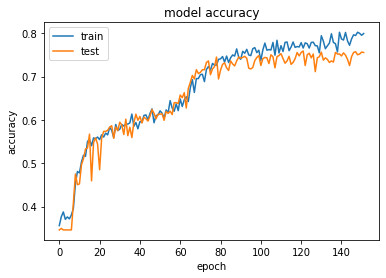

In [26]:

# model.load_weights('py/CNN/cnn')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(test_x,test_y)
pred_cy = model.predict_classes(test_x)

precision = precision_score(label_labelencoder_y, pred_cy, average='macro')
recall = recall_score(label_labelencoder_y, pred_cy, average='macro')
acc = accuracy_score(label_labelencoder_y, pred_cy)

f1 = f1_score(label_labelencoder_y, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}')
plot_acc(history)




In [27]:
#測試集
model.load_weights('py/CNN/cnn')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(test_x,test_y)
pred_cy = model.predict_classes(test_x)

precision = precision_score(label_labelencoder_y, pred_cy, average='macro')
recall = recall_score(label_labelencoder_y, pred_cy, average='macro')
acc = accuracy_score(label_labelencoder_y, pred_cy)

f1 = f1_score(label_labelencoder_y, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}')
# plot_acc(history)




250/250 [==============================] - 0s 596us/step
Loss: 0.5523621773719788
Accuracy: 0.7839999794960022
predict accurscy: 0.784, precision: 0.7870021030273812, recall: 0.794345238095238, f1: 0.7884469497880094


In [28]:
#訓練集
model.load_weights('py/CNN/cnn')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(train_x,train_y)
pred_cy = model.predict_classes(train_x)

precision = precision_score(label_labelencoder_x, pred_cy, average='macro')
recall = recall_score(label_labelencoder_x, pred_cy, average='macro')
acc = accuracy_score(label_labelencoder_x, pred_cy)

f1 = f1_score(label_labelencoder_x, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}')
# plot_acc(history)




6130/6130 [==============================] - 4s 635us/step
Loss: 0.4609488668293976
Accuracy: 0.8052202463150024
predict accurscy: 0.8052202283849919, precision: 0.8096705860537732, recall: 0.8080133449418098, f1: 0.8087433682122821


# VGG16

In [50]:
conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (112 ,112,3))

# conv_base.trainable = False
model = Sequential()
model.add(conv_base)
# model.add(Flatten())
# model.add(Dropout(0.5))
# model.add(Dense(64, activation = 'relu'))
# # model.add(Dropout(0.1))
# model.add(Dense(3, activation = 'softmax'))


# model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Flatten()) 
model.add(Dropout(0.5)) 
model.add(Dense(256, activation='relu')) 
# model.add(Dropout(0.5)) 
model.add(Dense(3, activation='softmax')) 
model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
modelcheckpoint = keras.callbacks.ModelCheckpoint(filepath='py/VGG16/vgg16_n', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
# reduceLronplateau = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.001, cooldown=0, min_lr=0)
reduceLronplateau=ReduceLROnPlateau(monitor='val_accuracy',
                             patience=5,
                             # 3 epochs 內acc沒下降就要調整LR
                             verbose=1,
                             factor=0.5,
                             # LR降為0.5
                             min_lr=0.00001
                             # 最小 LR 到0.00001就不再下降
                             )


# model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(lr=1e-4), metrics = ['accuracy'])

# history = model.fit(train_x, train_y, epochs=500, batch_size=32, verbose=1, callbacks=[modelcheckpoint, earlystopping, reduceLronplateau])

history = model.fit(train_x[:5000],train_y[:5000], epochs=500, batch_size=32, verbose=1,validation_data=(train_x[5000:],train_y[5000:]), callbacks=[modelcheckpoint, earlystopping, reduceLronplateau])

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_13 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 4608)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               1179904   
_________________________________________________________________
dense_26 (Dense)             (None, 3)                 771       
Total params: 15,895,363
Trainable params: 15,895,363
Non-trainable params: 0
_________________________________________________________________
Train on 5000 samples, validate on 1130 samples
Epoch 1/500
5000/5000 [==============================] - 10

250/250 [==============================] - 0s 588us/step
Loss: 1.0931486530303955
Accuracy: 0.3840000033378601
predict accurscy: 0.384, precision: 0.128, recall: 0.3333333333333333, f1: 0.18497109826589597


/user_data/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


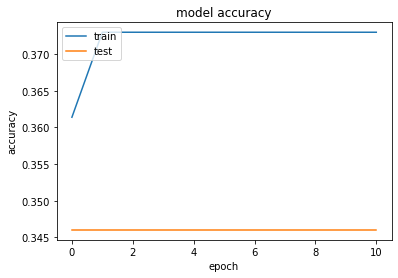

In [51]:

# model.load_weights('py/vgg16/vgg16_n')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(test_x,test_y)
pred_cy = model.predict_classes(test_x)

precision = precision_score(label_labelencoder_y, pred_cy, average='macro')
recall = recall_score(label_labelencoder_y, pred_cy, average='macro')
acc = accuracy_score(label_labelencoder_y, pred_cy)

f1 = f1_score(label_labelencoder_y, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}')
plot_acc(history)




In [52]:
#測試集
model.load_weights('py/VGG16/vgg16_n')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(test_x,test_y)
pred_cy = model.predict_classes(test_x)

precision = precision_score(label_labelencoder_y, pred_cy, average='macro')
recall = recall_score(label_labelencoder_y, pred_cy, average='macro')
acc = accuracy_score(label_labelencoder_y, pred_cy)

f1 = f1_score(label_labelencoder_y, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}')
# plot_acc(history)




250/250 [==============================] - 0s 587us/step
Loss: 1.093849515914917
Accuracy: 0.3840000033378601
predict accurscy: 0.384, precision: 0.128, recall: 0.3333333333333333, f1: 0.18497109826589597


/user_data/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
#訓練集
model.load_weights('py/VGG16/vgg16_n')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(train_x,train_y)
pred_cy = model.predict_classes(train_x)

precision = precision_score(label_labelencoder_x, pred_cy, average='macro')
recall = recall_score(label_labelencoder_x, pred_cy, average='macro')
acc = accuracy_score(label_labelencoder_x, pred_cy)

f1 = f1_score(label_labelencoder_x, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}')
# plot_acc(history)




6130/6130 [==============================] - 4s 607us/step
Loss: 1.0959790220851804
Accuracy: 0.36802610754966736
predict accurscy: 0.36802610114192497, precision: 0.12267536704730832, recall: 0.3333333333333333, f1: 0.1793465299308371


/user_data/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 資料增強

In [36]:
conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (224 ,224,3))

# conv_base.trainable = False
model = Sequential()
model.add(conv_base)
# model.add(Flatten())
# model.add(Dropout(0.5))
# model.add(Dense(64, activation = 'relu'))
# # model.add(Dropout(0.1))
# model.add(Dense(3, activation = 'softmax'))


# model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Flatten()) 
model.add(Dropout(0.5)) 
model.add(Dense(256, activation='relu')) 
# model.add(Dropout(0.5)) 
model.add(Dense(3, activation='softmax')) 
model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
modelcheckpoint = keras.callbacks.ModelCheckpoint(filepath='py/VGG16/vgg16', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
# reduceLronplateau = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.001, cooldown=0, min_lr=0)
reduceLronplateau=ReduceLROnPlateau(monitor='val_accuracy',
                             patience=5,
                             # 3 epochs 內acc沒下降就要調整LR
                             verbose=1,
                             factor=0.5,
                             # LR降為0.5
                             min_lr=0.00001
                             # 最小 LR 到0.00001就不再下降
                             )


# model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(lr=1e-4), metrics = ['accuracy'])
# train_datagen = ImageDataGenerator(rescale = 1./255)
# test_datagen = ImageDataGenerator(rescale = 1./255)
# train_datagen = ImageDataGenerator(rotation_range=0.2, zoom_range=0.05,
#                                    featurewise_center = True, featurewise_std_normalization = True,
#                                     width_shift_range=0.05, height_shift_range=0.05, shear_range=0.05,
#                                     horizontal_flip=True, fill_mode="nearest")
train_datagen=ImageDataGenerator(rotation_range=45 , 
                             width_shift_range=0.15 , 
                             height_shift_range=0.15 ,
                             shear_range=0.15 ,
                             zoom_range=0.15 , 
                             data_format='channels_last')

train_datagen.fit(train_x)
history = model.fit_generator(train_datagen.flow(train_x[:5000],train_y[:5000],batch_size=36), 
                              steps_per_epoch=100 , epochs=500,
                              validation_data=(train_x[5000:],train_y[5000:]),validation_steps=50,
                              callbacks=[modelcheckpoint, earlystopping, reduceLronplateau])

# model.fit(train_x, train_y, epochs=10, batch_size=64, verbose=1)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_12 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 25088)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dense_22 (Dense)             (None, 3)                 771       
Total params: 21,138,243
Trainable params: 21,138,243
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
100/100 [==============================] - 24s 245ms/step - loss: 1.2636 - accuracy: 0.3604 - v

In [37]:

# model.load_weights('py/CNN/cnn')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(test_x,test_y)
pred_cy = model.predict_classes(test_x)

precision = precision_score(label_labelencoder_y, pred_cy, average='macro')
recall = recall_score(label_labelencoder_y, pred_cy, average='macro')
acc = accuracy_score(label_labelencoder_y, pred_cy)

f1 = f1_score(label_labelencoder_y, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}')
# plot_acc(history)




250/250 [==============================] - 1s 5ms/step
Loss: 1.0928948860168457
Accuracy: 0.3840000033378601
predict accurscy: 0.384, precision: 0.128, recall: 0.3333333333333333, f1: 0.18497109826589597


/user_data/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
#測試集
model.load_weights('py/VGG16/vgg16')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(test_x,test_y)
pred_cy = model.predict_classes(test_x)

precision = precision_score(label_labelencoder_y, pred_cy, average='macro')
recall = recall_score(label_labelencoder_y, pred_cy, average='macro')
acc = accuracy_score(label_labelencoder_y, pred_cy)

f1 = f1_score(label_labelencoder_y, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}')
# plot_acc(history)




250/250 [==============================] - 1s 2ms/step
Loss: 1.097076919555664
Accuracy: 0.3840000033378601
predict accurscy: 0.384, precision: 0.128, recall: 0.3333333333333333, f1: 0.18497109826589597


/user_data/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
#訓練集
model.load_weights('py/VGG16/vgg16')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(train_x,train_y)
pred_cy = model.predict_classes(train_x)

precision = precision_score(label_labelencoder_x, pred_cy, average='macro')
recall = recall_score(label_labelencoder_x, pred_cy, average='macro')
acc = accuracy_score(label_labelencoder_x, pred_cy)

f1 = f1_score(label_labelencoder_x, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}')
# plot_acc(history)




6130/6130 [==============================] - 13s 2ms/step
Loss: 1.0971271055168663
Accuracy: 0.36802610754966736
predict accurscy: 0.36802610114192497, precision: 0.12267536704730832, recall: 0.3333333333333333, f1: 0.1793465299308371


/user_data/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
